# TFPT — Alpha only

This notebook is focused purely on $\alpha$.

Roadmap:

- ### 7.2 Ein Parameter Normalform für $\alpha$: Darstellung nur in $c_{3}$
- CODATA 2022 comparison
- ### 7.5 Alternative Näherungen und optimierte Berechnungsarten
- ### 7.6 Variationsableitung in vier Dimensionen  (kubische Fixpunktgleichung aus der Einstein Wirkung)
- #### 7.6.1 Callan–Symanzik Route

In [1]:
from decimal import Decimal, getcontext
import math, numpy as np, pandas as pd
import matplotlib.pyplot as plt
getcontext().prec = 60
PI = Decimal(str(math.pi))
b1   = Decimal(41) / Decimal(10)
phi0 = 1/(6*PI) + Decimal(3)/(256*(PI**4))
codata_alpha = Decimal("0.0072973525628")
c3_default = 1/(8*PI)
def D(x): return Decimal(str(x))

### 7.2 Ein Parameter Normalform für $\alpha$: Darstellung nur in $c_{3}$

With $\varphi_{0}$ and $b_{1}$ fixed, the cubic depends on $c_{3}$ only:

$$f(\alpha;c_{3})=\alpha^{3}-2c_{3}^{3}\alpha^{2}-8b_{1}c_{3}^{6}\ln\frac{1}{\varphi_{0}}=0.$$

In [2]:
def alpha_coeffs(c3: Decimal):
    B = -2*(c3**3)
    C = -8*b1*(c3**6)*((1/phi0).ln())
    return B, C
def alpha_cardano(c3: Decimal) -> Decimal:
    B, C = alpha_coeffs(c3)
    a = B; b = Decimal(0); c = C
    p = b - (a**2)/Decimal(3)
    q = (Decimal(2)*(a**3))/Decimal(27) - (a*b)/Decimal(3) + c
    Delta = (q/Decimal(2))**2 + (p/Decimal(3))**3
    sqrtDelta = Delta.sqrt()
    u = (-q/Decimal(2) + sqrtDelta) ** (Decimal(1)/Decimal(3))
    v = (-q/Decimal(2) - sqrtDelta) ** (Decimal(1)/Decimal(3))
    y = u + v
    return +(y - a/Decimal(3))
def alpha_practice(c3: Decimal) -> Decimal:
    term = (8*b1*(c3**6)*((1/phi0).ln())) ** (Decimal(1)/Decimal(3))
    return +(term + (Decimal(2)/Decimal(3))*(c3**3))
def alpha_newton(c3: Decimal, a0: Decimal, steps:int=1) -> Decimal:
    B, C = alpha_coeffs(c3)
    a = a0
    for _ in range(steps):
        f  = a**3 + B*a**2 + C
        df = 3*a**2 + 2*B*a
        a = a - f/df
    return +a
def alpha_halley(c3: Decimal, a0: Decimal, steps:int=1) -> Decimal:
    B, C = alpha_coeffs(c3)
    a = a0
    for _ in range(steps):
        f  = a**3 + B*a**2 + C
        df = 3*a**2 + 2*B*a
        d2f = 6*a + 2*B
        a = a - (2*f*df) / (2*df*df - f*d2f)
    return +a
alpha_exact = alpha_cardano(c3_default)
alpha_prac  = alpha_practice(c3_default)
alpha_new1  = alpha_newton(c3_default, alpha_prac, steps=1)
alpha_hal1  = alpha_halley(c3_default, alpha_prac, steps=1)
print('alpha exact =', alpha_exact, '  alpha inverse =', 1/alpha_exact)

alpha exact = 0.00729732581691922234755082569689546615182896899779712812538055   alpha inverse = 137.036501464885802684748249145414685546664904851987934535415


**CODATA 2022 comparison**

In [3]:
def ppm(x, y): return abs((x-y)/y)*Decimal(1_000_000)
print('delta vs CODATA  =', alpha_exact - codata_alpha)
print('diff in ppm      =', ppm(alpha_exact, codata_alpha))

delta vs CODATA  = -2.674588077765244917430310453384817103100220287187461945E-8
diff in ppm      = 3.66514849700369052508719286321614026745022856933391463490768


**Sanity plot** for the cubic near the physical root.

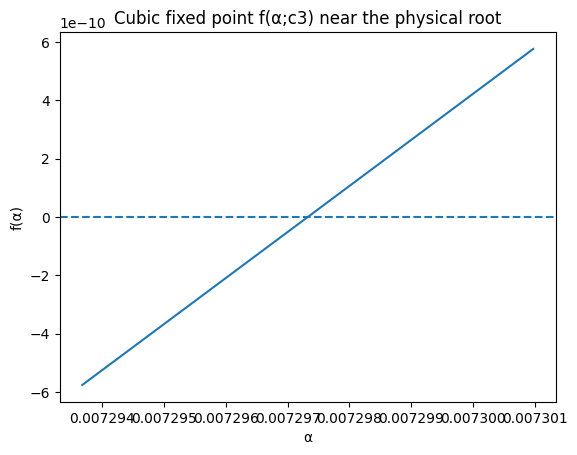

In [4]:
import numpy as np, matplotlib.pyplot as plt
x0 = float(alpha_exact)
xs = np.linspace(x0*0.9995, x0*1.0005, 500)
B, C = alpha_coeffs(c3_default)
def f_of_alpha(x):
    a = Decimal(str(x))
    return float(a**3 + B*a**2 + C)
ys = np.array([f_of_alpha(x) for x in xs])
plt.figure(); plt.plot(xs, ys); plt.axhline(0, linestyle='--')
plt.title('Cubic fixed point f(α;c3) near the physical root')
plt.xlabel('α'); plt.ylabel('f(α)'); plt.show()

**Response of $\alpha$ to $c_{3}$** near $c_{3}=1/(8\pi)$.

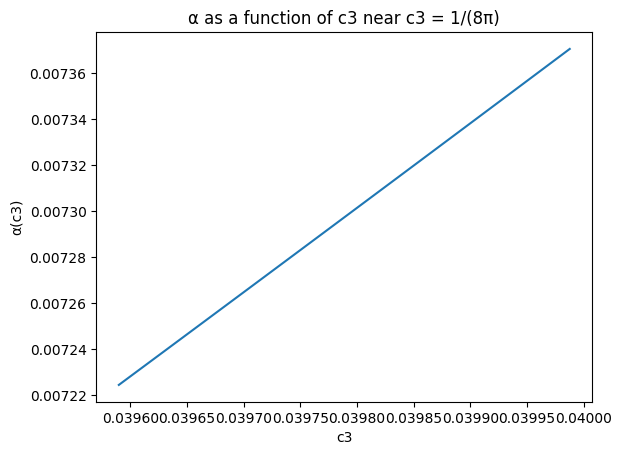

In [5]:
c3star = float(c3_default)
c3s = np.linspace(c3star*0.995, c3star*1.005, 50)
alphas = [float(alpha_cardano(Decimal(str(c)))) for c in c3s]
plt.figure(); plt.plot(c3s, alphas)
plt.title('α as a function of c3 near c3 = 1/(8π)')
plt.xlabel('c3'); plt.ylabel('α(c3)'); plt.show()

### 7.5 Alternative Näherungen und optimierte Berechnungsarten

           method     alpha     abs_error     ppm_error
0   Cardano exact  0.007297  0.000000e+00  0.000000e+00
1        Practice  0.007297 -2.440103e-07  3.343832e+01
2   Newton 1 step  0.007297  8.207167e-12  1.124681e-03
3   Halley 1 step  0.007297 -1.840252e-16  2.521817e-08
4  Newton 2 steps  0.007297  9.284185e-21  1.272272e-12
5  Halley 2 steps  0.007297 -7.893367e-44  1.081679e-35


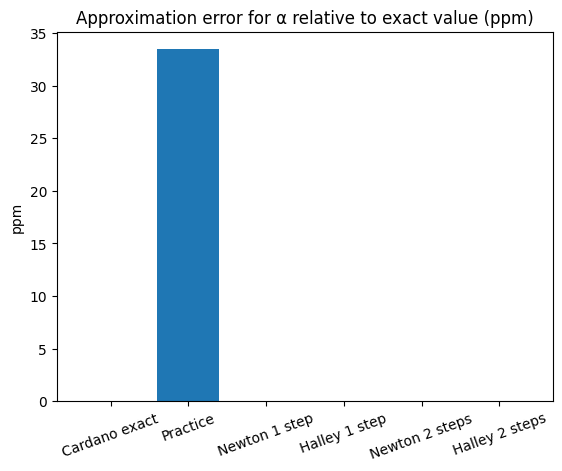

In [6]:
rows = []
methods = [
    ('Cardano exact', alpha_exact),
    ('Practice', alpha_prac),
    ('Newton 1 step', alpha_new1),
    ('Halley 1 step', alpha_hal1),
    ('Newton 2 steps', alpha_newton(c3_default, alpha_prac, steps=2)),
    ('Halley 2 steps', alpha_halley(c3_default, alpha_prac, steps=2)),
]
def ppm(x, y): return abs((x-y)/y)*Decimal(1_000_000)
for name, val in methods:
    rows.append({'method': name, 'alpha': float(val), 'abs_error': float(val - alpha_exact), 'ppm_error': float(ppm(val, alpha_exact))})
import pandas as pd
df_methods = pd.DataFrame(rows); print(df_methods)
plt.figure(); plt.bar(df_methods['method'], df_methods['ppm_error'])
plt.title('Approximation error for α relative to exact value (ppm)')
plt.ylabel('ppm'); plt.xticks(rotation=20); plt.show()

### 7.6 Variationsableitung in vier Dimensionen  (kubische Fixpunktgleichung aus der Einstein Wirkung)

U(alpha_exact) = -2.63821566860439598810012537279664213803956531121401421801242E-13
dU/dα at root  = 1.06939478E-62


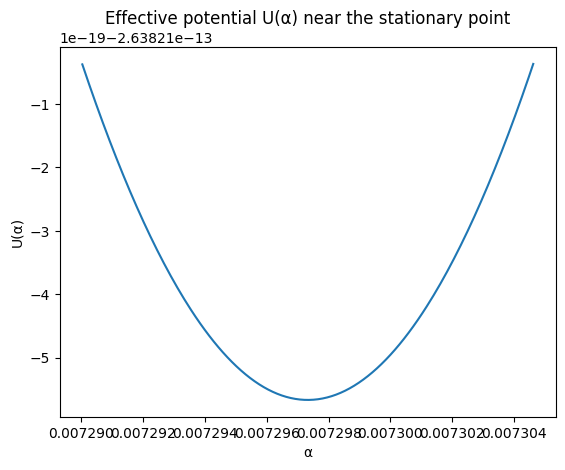

In [7]:
def U_alpha(c3: Decimal, a: Decimal) -> Decimal:
    A = 2*(c3**3)
    return +(A*a**4/Decimal(4) - (2*A*(c3**3)*a**3)/Decimal(3) - A*(8*b1*(c3**6)*((1/phi0).ln()))*a)
def dU_da(c3: Decimal, a: Decimal) -> Decimal:
    A = 2*(c3**3)
    return +(A*a**3 - 2*A*(c3**3)*a**2 - A*(8*b1*(c3**6)*((1/phi0).ln())))
print('U(alpha_exact) =', U_alpha(c3_default, alpha_exact))
print('dU/dα at root  =', dU_da(c3_default, alpha_exact))
x0 = float(alpha_exact)
xs = np.linspace(x0*0.999, x0*1.001, 200)
Us = [float(U_alpha(c3_default, Decimal(str(x)))) for x in xs]
plt.figure(); plt.plot(xs, Us)
plt.title('Effective potential U(α) near the stationary point')
plt.xlabel('α'); plt.ylabel('U(α)'); plt.show()

#### 7.6.1 Callan–Symanzik Route

In [8]:
PI = Decimal(str(math.pi))
kappa = (b1/(2*PI))*((1/phi0).ln())
A = 2*(c3_default**3)
lhs = dU_da(c3_default, alpha_exact)
rhs = A * (alpha_exact**3 - 2*(c3_default**3)*(alpha_exact**2) - 8*b1*(c3_default**6)*((1/phi0).ln()))
print('dU/dα numeric:', lhs)
print('A times cubic:', rhs)

dU/dα numeric: 1.06939478E-62
A times cubic: 1.06939477875756288388844384563014519173483600474889620785506E-62
